### calculate the leadtime-dependent climatological terciles, deciles and percentiles (0.02, then 0.05 to 0.95 with 0.05 step) from the individual GCMs' hindcast dataset (period 1993 - 2016) for countries 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os and standard libraries 
import os
import sys
from collections import OrderedDict
from itertools import product

### datetimes
from datetime import datetime, timedelta

### scipy
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import dask
from dask.diagnostics import ProgressBar
from tqdm import tqdm

### plotting
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns


In [3]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [4]:
sys.path.append('../../') 

In [5]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

### dictionnary holding quantile name and quantile values, they are passed as **lists** to avoid any numerical issues 

In [6]:
dict_quantiles = OrderedDict()
dict_quantiles['tercile'] = [0.3333, 0.6666]
dict_quantiles['decile'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dict_quantiles['percentile'] = [0.02, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95] 

### variables 

### provider 

In [7]:
provider = 'CDS'

### variable name in the hindcast dataset 

In [8]:
varname = 'tprate'

### period: `monthly` or `seasonal` 

In [9]:
# period = 'monthly'
period = 'seasonal'

### list of valid GCMs 

In [10]:
GCMs = ['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP']

### selects the GCM here 

In [11]:
GCM = 'ECMWF'

### path definitions follow

#### where to find the GCM hindcast datasets 

In [12]:
gcm_path = pathlib.Path(f'/media/nicolasf/END19101/ICU/data/{provider}')

In [13]:
dpath = gcm_path.joinpath(GCM).joinpath(varname.upper())

In [14]:
print(dpath)

/media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE


#### where to save the climatologies 

In [15]:
clim_path = gcm_path.joinpath(f'CLIMATOLOGY/{GCM}')

In [16]:
clim_path

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/CLIMATOLOGY/ECMWF')

In [17]:
if not clim_path.exists(): 
    
    clim_path.mkdir(parents=True)

### get the list of files 

In [18]:
lfiles = list(dpath.glob(f"ensemble_seas_forecasts_{varname}_from_*_{GCM}.netcdf"))

In [19]:
lfiles.sort()

In [20]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE/ensemble_seas_forecasts_tprate_from_1993_01_ECMWF.netcdf')

In [21]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE/ensemble_seas_forecasts_tprate_from_2021_04_ECMWF.netcdf')

In [22]:
len(lfiles)

338

### open the multiple files dataset, concatenating over the time dimension, and preprocessing 

In [23]:
dset = xr.open_mfdataset(lfiles, preprocess=C3S.preprocess_GCM, parallel=True, engine='netcdf4')

In [24]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (member: 51, time: 338, lon: 126, lat: 86, step: 5)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2021-04-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 242.0 243.0 244.0 245.0
  * lat      (lat) float32 -55.0 -54.0 -53.0 -52.0 -51.0 ... 27.0 28.0 29.0 30.0
  * step     (step) int64 1 2 3 4 5
Data variables:
    tprate   (time, step, member, lat, lon) float32 dask.array<chunksize=(1, 5, 51, 86, 126), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 19:56:10 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...>

### print the number of members in the ensemble for each time step 

In [25]:
# for t in range(len(dset.time)): 
    
#     s = dset.isel(time=t)
    
#     print(f"{pd.to_datetime(dset.isel(time=t)['time'].data):%Y-%m}:", len(s.dropna('member')['member']))

### selects the hindcast period 

In [26]:
dset = dset.sel(time=slice('1993', '2016'))

In [27]:
dset

,Array,Chunk
Bytes,2.96 GiB,10.54 MiB
Shape,"(288, 5, 51, 86, 126)","(1, 5, 51, 86, 126)"
Count,2955 Tasks,288 Chunks
Type,float32,numpy.ndarray


### convert to monthly rainfall accumulations (mm/month)

In [28]:
dset.tprate.attrs

{'units': 'm s**-1', 'long_name': 'Mean total precipitation rate'}

In [29]:
dset = C3S.convert_rainfall(dset, varin='tprate', varout='precip', leadvar='step', timevar='time', dropvar=True)


unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in var = precip


In [30]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (member: 51, time: 288, lon: 126, lat: 86, step: 5)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 242.0 243.0 244.0 245.0
  * lat      (lat) float32 -55.0 -54.0 -53.0 -52.0 -51.0 ... 27.0 28.0 29.0 30.0
  * step     (step) int64 1 2 3 4 5
Data variables:
    precip   (time, step, member, lat, lon) float64 dask.array<chunksize=(1, 5, 51, 86, 126), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 19:56:10 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...>

In [31]:
dset.precip.attrs

{'units': 'mm/month'}

### make sure there are no negative values 

In [32]:
dset = dset.clip(min=0)

### if the period is set to `seasonal`, calculates the seasonal accumulations 

In [33]:
if period == 'seasonal': 
    
    dset = dset.rolling({'step':3}, min_periods=3).sum('step')
    
    dset = dset.sel({'step':slice(3, None)})

In [34]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (member: 51, time: 288, lon: 126, lat: 86, step: 3)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 242.0 243.0 244.0 245.0
  * lat      (lat) float32 -55.0 -54.0 -53.0 -52.0 -51.0 ... 27.0 28.0 29.0 30.0
  * step     (step) int64 3 4 5
Data variables:
    precip   (time, step, member, lat, lon) float64 dask.array<chunksize=(1, 3, 51, 86, 126), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 19:56:10 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...>

In [35]:
steps = dset.step.data

In [36]:
steps

array([3, 4, 5])

### calculate percentiles over the dimensions member and time, will then be lead time dependent 

In [37]:
def calc_percentiles(dset, percentiles=None, dims=['member','time']):
    """
    calculates the climatological percentiles, over dimensions 
    ['member','time'] from a CDS hindcast dataset 
    
    Arguments
    ---------
    
    Returns
    -------
    """
    if percentiles is None: 
        
        percentiles = np.insert(np.arange(0.05, 1., 0.05), 0, 0.02)
        
    return dset.quantile(percentiles, dim=dims) 

In [38]:
# coastlines_dpath = '/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles'


In [39]:
coastlines_dpath = pathlib.Path('/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/ICU/') 

In [40]:
shapefile = gpd.read_file(coastlines_dpath.joinpath('ICU_coastlines_geometries0_360.shp'))

In [41]:
shapefile.head(3)

,OBJECTID,COUNTRY_ID,COUNTRYNAM,ICU,Stress,SOPAC,FFA,SPC,SPREP,USP,TCSP,FORUM,ACP,area,Shape_Leng,Shape_Area,geometry
0,1.0,NC,New Caledonia,2.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.331204,1.639128,"MULTIPOLYGON (((166.933 -22.882, 166.933 -22.8..."
1,2.0,PN,Pitcairn Islands,-3.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.733043,0.004720,"MULTIPOLYGON (((229.905 -25.069, 229.905 -25.0..."
2,3.0,PG,Papua New Guinea,-3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,229.361133,37.800908,"MULTIPOLYGON (((153.509 -11.620, 153.508 -11.6..."


In [42]:
shapefile.columns

Index(['OBJECTID', 'COUNTRY_ID', 'COUNTRYNAM', 'ICU', 'Stress', 'SOPAC', 'FFA',
       'SPC', 'SPREP', 'USP', 'TCSP', 'FORUM', 'ACP', 'area', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')

In [43]:
location_col = 'COUNTRYNAM'

In [44]:
country_names = shapefile[location_col].values.tolist()

In [45]:
len(country_names)

29

In [46]:
country_names

['New Caledonia',
 'Pitcairn Islands',
 'Papua New Guinea',
 'Solomon Islands',
 'Kiribati: Phoenix Islands',
 'Fiji',
 'Tuvalu',
 'Northern Cook Islands',
 'Kiribati: Line Islands',
 'Federated States of Micronesia',
 'Samoa',
 'Kiribati: Gilbert Islands',
 'Wallis & Futuna',
 'Tokelau',
 'Tuamotu / Gambier Islands',
 'Tonga',
 'Niue',
 'Southern Cook Islands',
 'Austral Islands',
 'Society Islands',
 'Marquesas',
 'Vanuatu South',
 'Vanuatu North',
 'Guam',
 'Northern Marianas',
 'Marshall Islands',
 'Nauru',
 'Palau',
 'American Samoa']

In [47]:
# shape_name = 'Papua New Guinea'
shape_name = 'Kiribati: Gilbert Islands'
# shape_name = 'Fiji'

In [48]:
shape = shapefile.query(f"{location_col} == '{shape_name}'")

In [49]:
if not(shape.crs): 
    print("setting CRS")
    shape = shape.set_crs("EPSG:4326")

setting CRS


<AxesSubplot:>

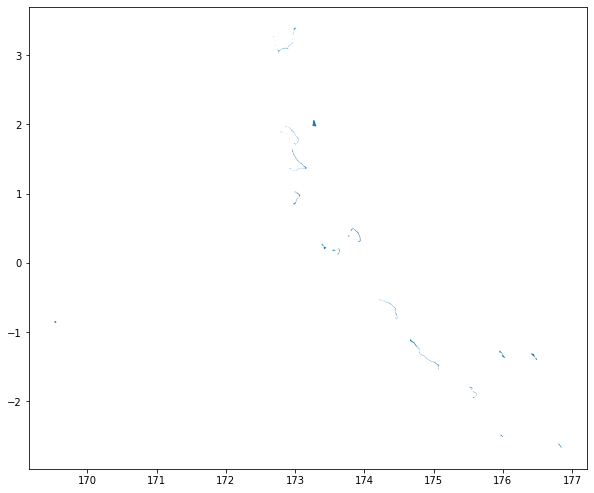

In [50]:
shape.plot(figsize=(10,10))

### for Island groups consituted of very small islands / atolls, we don't filter OUT the geometries, we actually buffer them  so that they can match the resolution of the GCM (once interpolated)

In [51]:
float(shape.to_crs('EPSG:3857').area / 10**6)

366.3128369983124

In [52]:
if float(shape.to_crs('EPSG:3857').area / 10**6) < 1000: 
    shape = shape.buffer(0.5)

<AxesSubplot:>

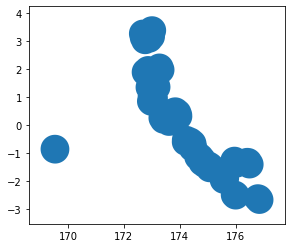

In [53]:
shape.plot()

### get the initial domain

In [54]:
initial_domain = geo.get_shape_bounds(shape)

In [55]:
initial_domain

[169.0213069801801, 177.34860777748426, -3.1730555298887566, 3.895623361970928]

### filter by area, we are only keeping the large Islands 

In [56]:
# shape = geo.filter_by_area(shape)

<AxesSubplot:>

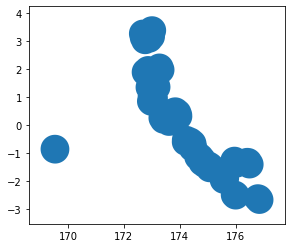

In [57]:
shape.plot()

### we use these filtered geometries to mask the GCM hindcast dataset

#### Note that the GCM dataset is first interpolated to 5X its original resolution 

In [58]:
dset

,Array,Chunk
Bytes,3.56 GiB,12.65 MiB
Shape,"(288, 3, 51, 86, 126)","(1, 3, 51, 86, 126)"
Count,12746 Tasks,288 Chunks
Type,float64,numpy.ndarray


In [59]:
dset, domain = geo.mask_dataset(dset, shape, coastline_buffer=0)

[########################################] | 100% Completed | 16.1s


In [60]:
dset

<xarray.Dataset>
Dimensions:  (member: 51, time: 288, step: 3, lat: 45, lon: 50)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 3 4 5
  * lon      (lon) float64 169.0 169.2 169.4 169.6 ... 177.4 177.6 177.8 178.0
  * lat      (lat) float64 -4.0 -3.818 -3.636 -3.455 ... 3.455 3.636 3.818 4.0
Data variables:
    precip   (time, step, member, lat, lon) float64 nan nan nan ... nan nan nan
    mask     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 19:56:10 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

### number of grid points 

In [61]:
dset['mask'].attrs['cells']

347

### plots the mask 

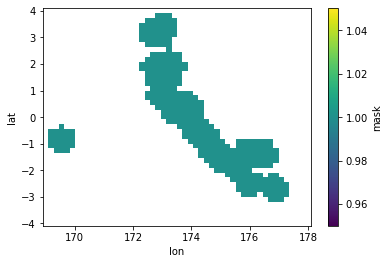

In [62]:
dset['mask'].plot()

### plots the precipitation field for one time step, leadtime and member 

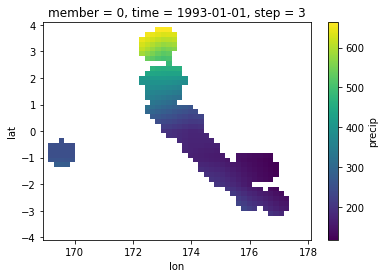

In [63]:
dset.isel(time=0, step=0, member=0)['precip'].plot()

### calculates the regional average (average over lats and lons)

In [64]:
dset_sub = dset.mean(['lat','lon'])

### and the calculates the climatological percentiles 

#### terciles 

In [65]:
quantiles = 'tercile'

In [66]:
clim_p = dset_sub[['precip']].groupby(dset_sub.time.dt.month).apply(calc_percentiles, **{'percentiles':dict_quantiles[quantiles]})

### plot the climatological quantiles as a function of leadtime ('step' dimension)

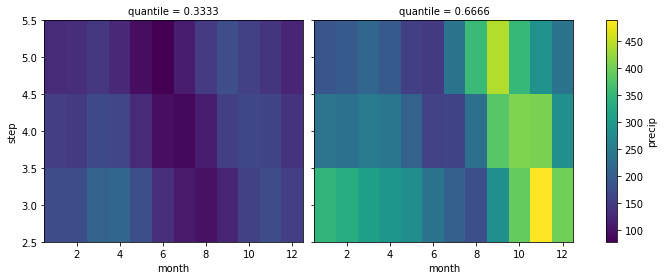

In [67]:
clim_p['precip'].plot(x='month', y = 'step', col='quantile', figsize=(10, 4))

In [68]:
dset_sub

<xarray.Dataset>
Dimensions:  (member: 51, time: 288, step: 3)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 3 4 5
Data variables:
    precip   (time, step, member) float64 269.1 382.6 687.7 ... nan nan nan
    mask     float64 1.0

In [69]:
clim_p

<xarray.Dataset>
Dimensions:   (month: 12, quantile: 2, step: 3)
Coordinates:
  * step      (step) int64 3 4 5
  * quantile  (quantile) float64 0.3333 0.6666
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip    (month, quantile, step) float64 171.9 152.6 127.3 ... 282.1 234.3

### need to save the climatologies 

### digitize: each member is given a category depending on the percentile bins defined earlier 

In [70]:
dset_cat = []

for month in np.arange(12) + 1: 
    
    x = dset_sub.sel(time=(dset_sub.time.dt.month == month))
    
    # drop the missing members 
    
    x = x.dropna('member')
    
    # digitize

    qc = C3S.get_GCM_category_digitize(x, clim_p.sel(month=month), varname='precip', dim='quantile')
    
    dset_cat.append(qc)

### concatenates over the time dimension and reorder 

In [71]:
dset_cat = xr.concat(dset_cat, dim='time')
dset_cat = dset_cat.sortby('time')

In [72]:
dset_cat

<xarray.Dataset>
Dimensions:  (member: 25, time: 288, step: 3)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 3 4 5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, step, member) int64 2 3 3 3 3 3 3 3 3 ... 1 1 2 2 1 2 1 2 1

### Now calculates the probabilities as the proportion of members falling into each category 

In [73]:
quantiles_category_percent = C3S.calculate_quantiles_probabilities(dset_cat, ncategories=3)

In [74]:
quantiles_category_percent

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 288, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 3 4 5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * tercile  (tercile) int64 1 2 3
Data variables:
    precip   (tercile, time, step) float64 0.0 12.0 20.0 0.0 ... 4.0 0.0 0.0 0.0

### because of numerical approximations, sometimes the sum over the quantile dimension is not strictly equal to 100.

In [75]:
np.alltrue((quantiles_category_percent.sum('tercile')['precip'] == 100.))

<xarray.DataArray 'precip' ()>
array(False)

### but it is close enough 

In [76]:
np.alltrue((quantiles_category_percent.sum('tercile')['precip'] >= 99.9999))

<xarray.DataArray 'precip' ()>
array(True)

In [77]:
np.alltrue((quantiles_category_percent.sum('tercile')['precip'] <= 100.0001))

<xarray.DataArray 'precip' ()>
array(True)

In [78]:
quantiles_category_percent

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 288, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 3 4 5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * tercile  (tercile) int64 1 2 3
Data variables:
    precip   (tercile, time, step) float64 0.0 12.0 20.0 0.0 ... 4.0 0.0 0.0 0.0

### takes the percentile probabilities for one lead time, then casts into a pandas dataframe 

#### these are the leadtimes, in months, should be [1,2,3,4,5] if monthly, [3,4,5] if seasonal 

In [79]:
quantiles_category_percent

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 288, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 3 4 5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * tercile  (tercile) int64 1 2 3
Data variables:
    precip   (tercile, time, step) float64 0.0 12.0 20.0 0.0 ... 4.0 0.0 0.0 0.0

In [80]:
df_quantile_probabilities = []

for step in steps: 
    
    df = quantiles_category_percent.sel(step=step)['precip'].to_pandas().T
    
    cols = pd.MultiIndex.from_product([[step], df.columns]) 

    df.columns = cols 
    
    df_quantile_probabilities.append(df)


In [81]:
df_quantile_probabilities = pd.concat(df_quantile_probabilities, axis=1) 

In [82]:
df_quantile_probabilities.head()

3                  4                 5            
tercile       1     2      3     1     2     3     1     2     3
time                                                            
1993-01-01  0.0  24.0   76.0  12.0  40.0  48.0  20.0  44.0  36.0
1993-02-01  0.0  12.0   88.0   0.0  16.0  84.0   0.0  28.0  72.0
1993-03-01  4.0  36.0   60.0   0.0  20.0  80.0   0.0  12.0  88.0
1993-04-01  0.0   0.0  100.0   0.0   4.0  96.0   0.0  12.0  88.0
1993-05-01  0.0   8.0   92.0   0.0  16.0  84.0   0.0  36.0  64.0

In [83]:
df_quantile_probabilities.tail()

3                4                5           
tercile        1     2    3     1     2    3     1     2    3
time                                                         
2016-08-01  96.0   4.0  0.0  96.0   4.0  0.0  92.0   8.0  0.0
2016-09-01  88.0  12.0  0.0  72.0  28.0  0.0  68.0  32.0  0.0
2016-10-01  88.0  12.0  0.0  72.0  28.0  0.0  64.0  36.0  0.0
2016-11-01  72.0  24.0  4.0  84.0  12.0  4.0  76.0  20.0  4.0
2016-12-01  60.0  40.0  0.0  72.0  28.0  0.0  64.0  36.0  0.0

In [84]:
opath_q_probs = pathlib.Path(f'../../outputs/C3S/countries_climatologies/{quantiles}')

In [85]:
if not(opath_q_probs.exists()): 
    opath_q_probs.mkdir(parents=True)

### saves to disk 

In [86]:
utils.sanitize_name(shape_name)

'Kiribati_Gilbert_Islands'

In [87]:
df_quantile_probabilities.to_csv(opath_q_probs.joinpath(f"{utils.sanitize_name(shape_name)}_{period}_{GCM}_{quantiles}_probs.csv"))

In [129]:
df_quantile_probabilities

3                  4                 5            
tercile        1     2      3     1     2     3     1     2     3
time                                                             
1993-01-01   0.0  24.0   76.0  12.0  40.0  48.0  20.0  44.0  36.0
1993-02-01   0.0  12.0   88.0   0.0  16.0  84.0   0.0  28.0  72.0
1993-03-01   4.0  36.0   60.0   0.0  20.0  80.0   0.0  12.0  88.0
1993-04-01   0.0   0.0  100.0   0.0   4.0  96.0   0.0  12.0  88.0
1993-05-01   0.0   8.0   92.0   0.0  16.0  84.0   0.0  36.0  64.0
...          ...   ...    ...   ...   ...   ...   ...   ...   ...
2016-08-01  96.0   4.0    0.0  96.0   4.0   0.0  92.0   8.0   0.0
2016-09-01  88.0  12.0    0.0  72.0  28.0   0.0  68.0  32.0   0.0
2016-10-01  88.0  12.0    0.0  72.0  28.0   0.0  64.0  36.0   0.0
2016-11-01  72.0  24.0    4.0  84.0  12.0   4.0  76.0  20.0   4.0
2016-12-01  60.0  40.0    0.0  72.0  28.0   0.0  64.0  36.0   0.0

[288 rows x 9 columns]

### Now we are going to read the ERA5 reanalysis precipitation data for the validation of the regional aggregates 

In [88]:
from ICU_Water_Watch import verification

In [89]:
use_verif = 'era'

In [90]:
dset_obs, dset_anomalies = verification.get_era5()

In [91]:
gcm_domain = domains.get_domain(dset)

In [92]:
gcm_domain

[169.0, 178.0, -4.0, 4.0]

In [93]:
dset_obs = dset_obs.sel(lon=slice(*gcm_domain[:2]), lat=slice(*gcm_domain[2:]))

In [94]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 288, lat: 9, lon: 10)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lat      (lat) float64 -4.0 -3.0 -2.0 -1.0 0.0 1.0 2.0 3.0 4.0
  * lon      (lon) float64 169.0 170.0 171.0 172.0 ... 175.0 176.0 177.0 178.0
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1, 9, 10), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-21 14:37:06 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

### if seasonal, calculates the 3 months accumulations 

In [95]:
if period == 'seasonal': 
    
    dset_obs = dset_obs.rolling({"time":3}, min_periods=3, center=False).sum('time')
    
    dset_obs = dset_obs.isel(time=slice(2, None))

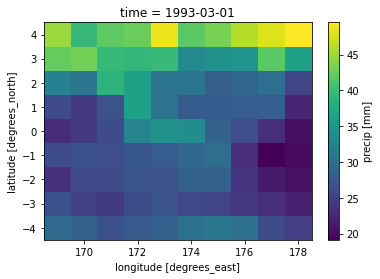

In [96]:
dset_obs['precip'][0,:,:].plot()

In [97]:
dset_obs = dset_obs.interp_like(dset[['lon','lat']])

In [98]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 286, lat: 45, lon: 50)
Coordinates:
  * time     (time) datetime64[ns] 1993-03-01 1993-04-01 ... 2016-12-01
  * lon      (lon) float64 169.0 169.2 169.4 169.6 ... 177.4 177.6 177.8 178.0
  * lat      (lat) float64 -4.0 -3.818 -3.636 -3.455 ... 3.455 3.636 3.818 4.0
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1, 45, 50), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-21 14:37:06 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

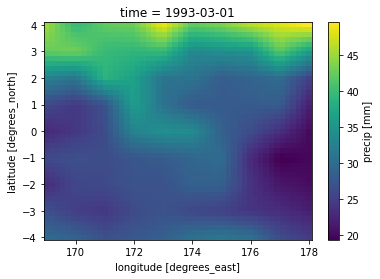

In [99]:
dset_obs['precip'][0,:,:].plot()

### insert the mask from the GCM dataset

In [100]:
dset_obs['mask'] = dset['mask']

### same grid and same mask as the GCM 

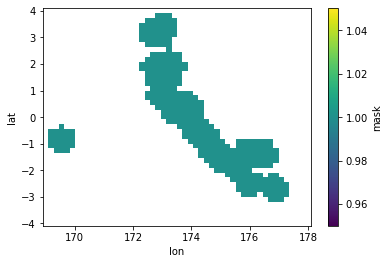

In [101]:
dset['mask'].plot()

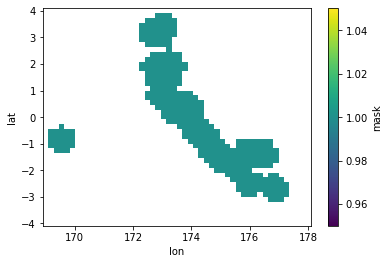

In [102]:
dset_obs['mask'].plot()

### apply the mask 

In [103]:
dset_obs['precip'] = dset_obs['precip'] * dset_obs['mask']

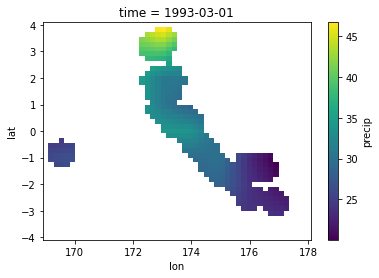

In [104]:
dset_obs.isel(time=0).squeeze()['precip'].plot()

### insert a dummy "member" dimension with one coordinate

In [105]:
dset_obs = dset_obs.expand_dims({'member':[1]})

### calculates the regional average 

In [106]:
dset_obs_sub = dset_obs[['precip']].mean(['lat','lon'])

In [107]:
dset_obs_sub

<xarray.Dataset>
Dimensions:  (member: 1, time: 286)
Coordinates:
  * member   (member) int64 1
  * time     (time) datetime64[ns] 1993-03-01 1993-04-01 ... 2016-12-01
Data variables:
    precip   (member, time) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [108]:
dset_obs_sub = dset_obs_sub.chunk({'member':-1, 'time':-1})

In [109]:
with ProgressBar(): 
    dset_obs_sub = dset_obs_sub.compute()

[########################################] | 100% Completed |  3.3s


### Now calculates the climatological percentiles for the observations, per month 

In [110]:
quantiles

'tercile'

In [111]:
clim_obs_p = dset_obs_sub[['precip']].groupby(dset_obs_sub.time.dt.month).apply(calc_percentiles, **{'percentiles':dict_quantiles[quantiles]})

### Now calculates the categories, based on the observations, for each month or season 

In [112]:
dset_obs_cat = []

for month in np.arange(12) + 1: 
    
    x = dset_obs_sub.sel(time=(dset_obs_sub.time.dt.month == month))

    # digitize

    qc = C3S.get_GCM_category_digitize(x, clim_obs_p.sel(month=month), varname='precip', dim='quantile')
    
    dset_obs_cat.append(qc)

In [113]:
dset_obs_cat = xr.concat(dset_obs_cat, dim='time')

In [114]:
dset_obs_cat = dset_obs_cat.sortby('time')

In [115]:
dset_obs_cat = dset_obs_cat.squeeze()['precip'].to_pandas()

In [116]:
dset_obs_cat

time
1993-03-01    3
1993-04-01    3
1993-05-01    3
1993-06-01    3
1993-07-01    3
             ..
2016-08-01    1
2016-09-01    1
2016-10-01    1
2016-11-01    1
2016-12-01    1
Length: 286, dtype: int64

### Now evaluate the forecasts compared to the observations 

In [117]:
df_quantile_probabilities

3                  4                 5            
tercile        1     2      3     1     2     3     1     2     3
time                                                             
1993-01-01   0.0  24.0   76.0  12.0  40.0  48.0  20.0  44.0  36.0
1993-02-01   0.0  12.0   88.0   0.0  16.0  84.0   0.0  28.0  72.0
1993-03-01   4.0  36.0   60.0   0.0  20.0  80.0   0.0  12.0  88.0
1993-04-01   0.0   0.0  100.0   0.0   4.0  96.0   0.0  12.0  88.0
1993-05-01   0.0   8.0   92.0   0.0  16.0  84.0   0.0  36.0  64.0
...          ...   ...    ...   ...   ...   ...   ...   ...   ...
2016-08-01  96.0   4.0    0.0  96.0   4.0   0.0  92.0   8.0   0.0
2016-09-01  88.0  12.0    0.0  72.0  28.0   0.0  68.0  32.0   0.0
2016-10-01  88.0  12.0    0.0  72.0  28.0   0.0  64.0  36.0   0.0
2016-11-01  72.0  24.0    4.0  84.0  12.0   4.0  76.0  20.0   4.0
2016-12-01  60.0  40.0    0.0  72.0  28.0   0.0  64.0  36.0   0.0

[288 rows x 9 columns]

In [118]:
quantiles

'tercile'

In [119]:
def compare(df): 
    acc = (df.forecast == df.obs).sum() / len(df)
    return acc

In [120]:
validation = {}
validation_seasonal = {}

validation[shape_name] = {}
validation_seasonal[shape_name] = {}

for step in steps: 
    
    df_hindcasts = df_quantile_probabilities.xs(step, axis=1, level=0)
    
    df_hindcasts.index = df_hindcasts.index + pd.offsets.MonthBegin(step)
    
    df_hindcasts_most_likely_category = df_hindcasts.idxmax(axis=1)
    
    print(50 * "-")
    print(f"\nrelative frequency of the {quantiles} categories:\n") 
    print(pd.value_counts(df_hindcasts_most_likely_category) / len(df_hindcasts_most_likely_category))
        
    df_merge = pd.concat([df_hindcasts_most_likely_category.to_frame(name='forecast'), dset_obs_cat.to_frame(name='obs')], axis=1).dropna()

    acc = compare(df_merge)
    
    acc_seasonal = df_merge.groupby(df_merge.index.month).apply(compare)
    
    print("\nforecast accuracy\n")
    
    print((df_merge.forecast == df_merge.obs).sum() / len(df_merge))
    
    validation[shape_name][step] = acc 
    
    validation_seasonal[shape_name][step] = acc_seasonal

--------------------------------------------------

relative frequency of the tercile categories:

2    0.354167
1    0.326389
3    0.319444
dtype: float64

forecast accuracy

0.7719298245614035
--------------------------------------------------

relative frequency of the tercile categories:

2    0.368056
1    0.322917
3    0.309028
dtype: float64

forecast accuracy

0.7359154929577465
--------------------------------------------------

relative frequency of the tercile categories:

2    0.371528
3    0.315972
1    0.312500
dtype: float64

forecast accuracy

0.6713780918727915


In [121]:
validation = pd.DataFrame(validation)

In [122]:
validation

,Kiribati: Gilbert Islands
3,0.771930
4,0.735915
5,0.671378


In [123]:
pd.DataFrame(validation_seasonal[shape_name])

,3,4,5
time,,,
1,0.739130,0.913043,0.782609
2,0.739130,0.739130,0.826087
3,0.869565,0.826087,0.739130
4,0.708333,0.782609,0.652174
5,0.791667,0.583333,0.652174
6,0.750000,0.708333,0.541667
7,0.708333,0.666667,0.583333
8,0.791667,0.583333,0.500000
9,0.750000,0.708333,0.625000


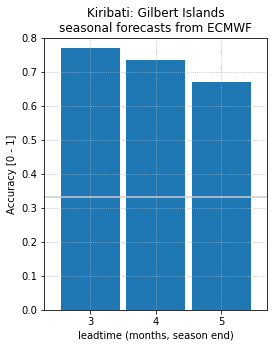

In [139]:
f = validation.plot(kind='bar', ylabel='Accuracy [0 - 1]', xlabel='leadtime (months, season end)', ylim=[None, 0.8], legend=None, figsize=(4,5), width=0.9) 
f.axes.set_title(f"{shape_name}\n{period} forecasts from {GCM}")
f.axes.axhline(0.3333, color='0.8')
f.axes.grid(ls=':')
[l.set_rotation(0) for l in f.axes.xaxis.get_ticklabels()]
fig = plt.gcf()
fig.savefig(f'/home/nicolasf/Desktop/{utils.sanitize_name(shape_name)}_{period}_{GCM}_{quantiles}_probs.png', dpi=200, bbox_inches='tight', facecolor='w')

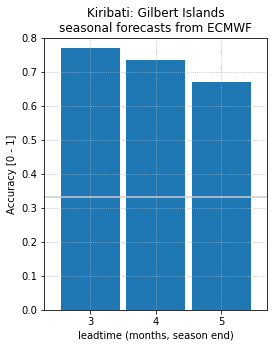

In [138]:
fig